# FOF analysis 

This notebook aims to show the main hotspot analysis between ANC and cross-sectional data 

## Importing modules

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import contextily as ctx
from spatial_tools import fof, clustering
from pregmal_pytools import spatial_utils
from epifriends import epifriends

## Import data 

In [2]:
#Importing data
mipmon, cross, cross210 = spatial_utils.import_spatial_data(serology_name = None)

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_utils.py:292: Se

## Defining masks and other definitions 

In [3]:
#MiPMon masks
has_geo_mip = mipmon['latitude'].notnull()&mipmon['longitude'].notnull()
has_pcr_mip = mipmon['pcrpos'].notnull()&has_geo_mip
mip_pcrpos = mipmon['pcrpos'] == 1
mip_pcrneg = mipmon['pcrpos'] == 0
mip_rdtpos = mipmon['density'] >= 100
mip_rdtneg = mipmon['density'] < 100
prenatal = (mipmon['visit'] == 'PN')&has_pcr_mip

#Define masks for MiPMon data
mipmon_pn = prenatal&has_geo_mip
mipmon_pg = mipmon_pn&(mipmon['gestnum'] == 1)
mipmon_sg = mipmon_pn&(mipmon['gestnum'] == 2)
mipmon_12g = mipmon_pn&(mipmon['gestnum'] <= 2)
mipmon_mg = mipmon_pn&(mipmon['gestnum'] > 1)
mipmon_3g = mipmon_pn&(mipmon['gestnum'] > 2)
mipmon_hiv_pos = mipmon_pn&(mipmon['hiv'] == 'HIV+')
mipmon_hiv_neg = mipmon_pn&(mipmon['hiv'] == 'HIV-')
mipmon_pg_hiv_pos = mipmon_pg&mipmon_hiv_pos
mipmon_pg_hiv_neg = mipmon_pg&mipmon_hiv_neg

mipmon_selection = {
    'All ANC visits' : mipmon_pn,
    'Primigravidae' : mipmon_pg,
    #'Secundigravid' : mipmon_sg,
    #'1-2gravid' : mipmon_12g,
    #'>2gravid' : mipmon_3g,
    'Multigravidae' : mipmon_mg,
    'HIV+' : mipmon_hiv_pos,
    'HIV-' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'Primigravid HIV-' : mipmon_pg_hiv_neg,
}

#Cross masks

cross210_area_mask = (cross210['area'] == 'Magude Sede')|(cross210['area'] == 'Manhiça')|(cross210['area'] == 'Ilha Josina')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Taninga')|(cross210['area'] == 'Panjane')
cross210_area_mask = cross210_area_mask |(cross210['area'] == 'Palmeira')
cross210_area_mask = cross210_area_mask | (cross210['area'] == 'Maragra')|(cross210['area'] == 'Malavele')
has_geo_cross210 = cross210['lat'].notnull()&cross210['lng'].notnull()
has_pcr_cross210 = cross210['pospcr'].notnull()&has_geo_cross210
has_rdt_cross210 = cross210['rdt'].notnull()&has_geo_cross210
cross210_pcrpos = cross210['pospcr'] == 1
cross210_pcrneg = cross210['pospcr'] == 0
cross210_rdtpos = cross210['rdt'] == 1
cross210_rdtneg = cross210['rdt'] == 0

cross_area_mask = (cross['area'] == 'Magude Sede')|(cross['area'] == 'Manhiça')|(cross['area'] == 'Ilha Josina')
cross_area_mask = cross_area_mask | (cross['area'] == 'Taninga')|(cross['area'] == 'Panjane')
cross_area_mask = cross_area_mask |(cross['area'] == 'Palmeira')
cross_area_mask = cross_area_mask | (cross['area'] == 'Maragra')|(cross['area'] == 'Malavele')
has_geo_cross = cross['lat'].notnull()&cross['lng'].notnull()
has_pcr_cross = cross['pospcr'].notnull()&has_geo_cross
has_rdt_cross = cross['rdt'].notnull()&has_geo_cross
cross_pcrpos = cross['pospcr'] == 1
cross_pcrneg = cross['pospcr'] == 0
cross_rdtpos = cross['rdt'] == 1
cross_rdtneg = cross['rdt'] == 0

#Defining x and y coordinates
mipmon = mipmon.to_crs(3857)
cross210 = cross210.to_crs(3857)
geo_mask = (mipmon['latitude'].notnull())&(mipmon['longitude'].notnull())
mipmon['x'] = mipmon['geometry'][geo_mask].apply(lambda p: p.x)
mipmon['y'] = mipmon['geometry'][geo_mask].apply(lambda p: p.y)
geo_mask = (cross210['lat'].notnull())&(cross210['lng'].notnull())
cross210['x'] = cross210['geometry'][geo_mask].apply(lambda p: p.x)
cross210['y'] = cross210['geometry'][geo_mask].apply(lambda p: p.y)
geo_mask = (cross['lat'].notnull())&(cross['lng'].notnull())
cross['x'] = cross['geometry'][geo_mask].apply(lambda p: p.x)
cross['y'] = cross['geometry'][geo_mask].apply(lambda p: p.y)

#Define names and positions of main locations
list_locs = {
    'Manhica' : [32.80722050, -25.40221980],
    'Magude' : [32.64216410, -25.02049992], 
    'Ilha Josina' : [32.92210000, -25.09330000], 
    }

locations = pd.DataFrame({'location' : [i for i in list_locs], 'longitude': [list_locs[i][0] for i in list_locs], 'latitude': [list_locs[i][1] for i in list_locs]})
locations = geopandas.GeoDataFrame(locations, geometry = geopandas.points_from_xy(locations['longitude'], locations['latitude']))
locations = locations.set_crs(epsg=4326)
locations = locations.to_crs(epsg=3857)

years = [1, 2, 3]

# Figures for paper 

In [4]:
ylims = [-2.95*10**6, -2.84*10**6]
xlims = [3.58*10**6, 3.69*10**6]

In [5]:
fontsize = 18

In [6]:
mipmon['rdt'] = 1*mipmon['pcrpos']
mipmon['rdt'][mipmon['density'] < 100] = 0

/tmp/ipykernel_216043/2565722842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mipmon['rdt'][mipmon['density'] < 100] = 0


#### qPCR

----------------------------------------
------------ Time window: None  -------------
------------ Year 1  -------------
Sample sizes:
MiPMon All ANC visits: 1971
Children 2-10: 1914
---------- Linking distance = 3000  ----------
Number of FOFs in Negative case/not in hotspot: 24
Number of FOFs in Negative case/not in hotspot with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 5
Number of FOFs in children 2-10: 9
Number of FOFs in children 2-10 with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


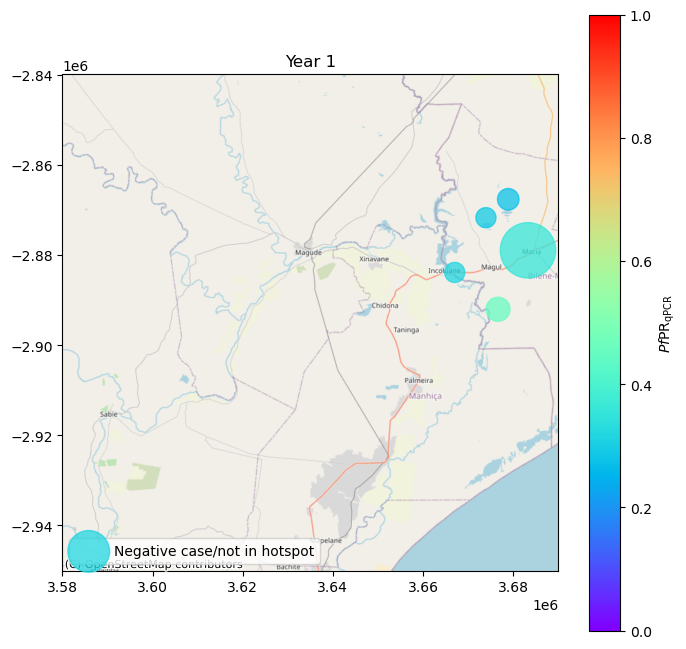

Number of FOFs: 5


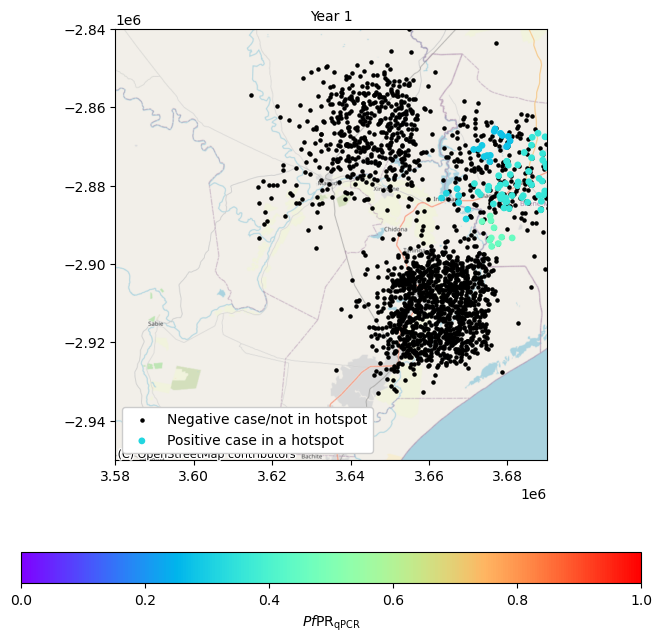

Number of FOFs: 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


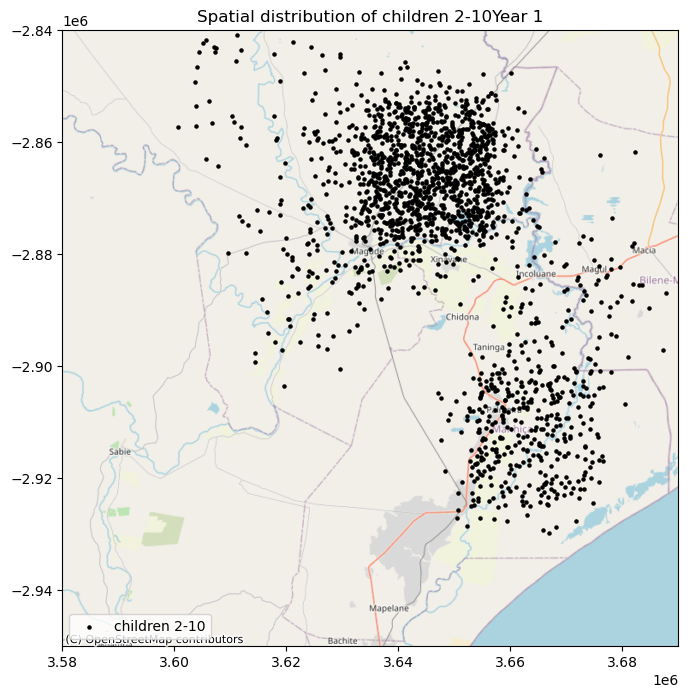

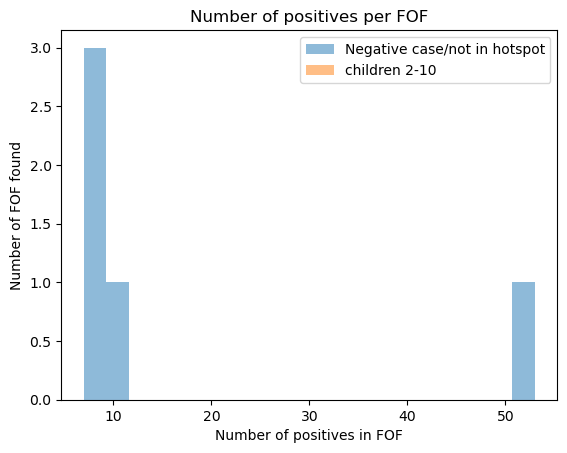

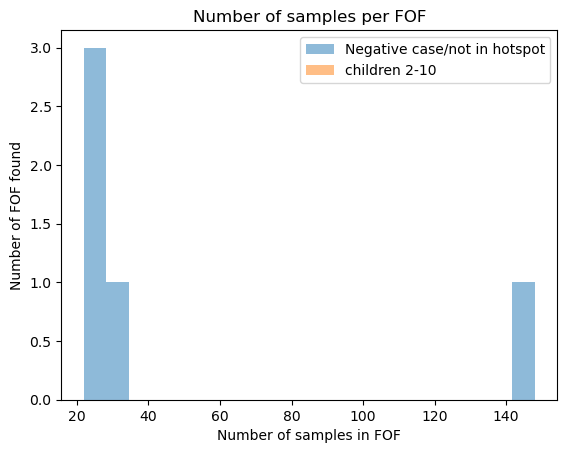

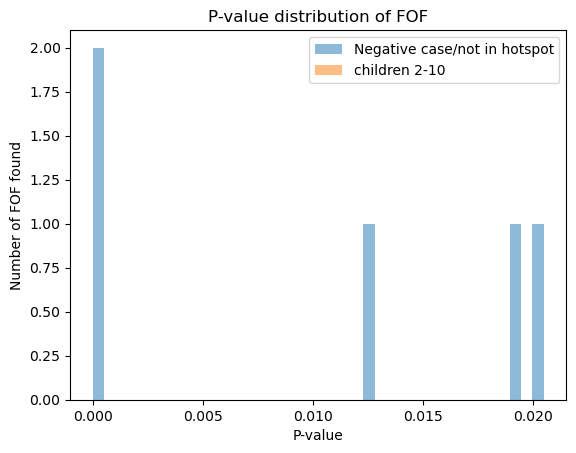

------------ Year 2  -------------
Sample sizes:
MiPMon All ANC visits: 1613
Children 2-10: 980
---------- Linking distance = 3000  ----------
Number of FOFs in Negative case/not in hotspot: 15
Number of FOFs in Negative case/not in hotspot with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 3
Number of FOFs in children 2-10: 7
Number of FOFs in children 2-10 with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


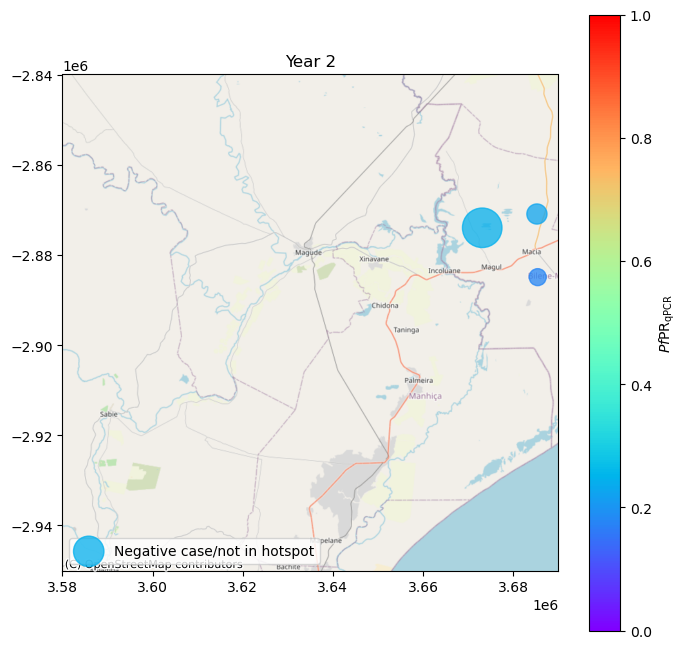

Number of FOFs: 3


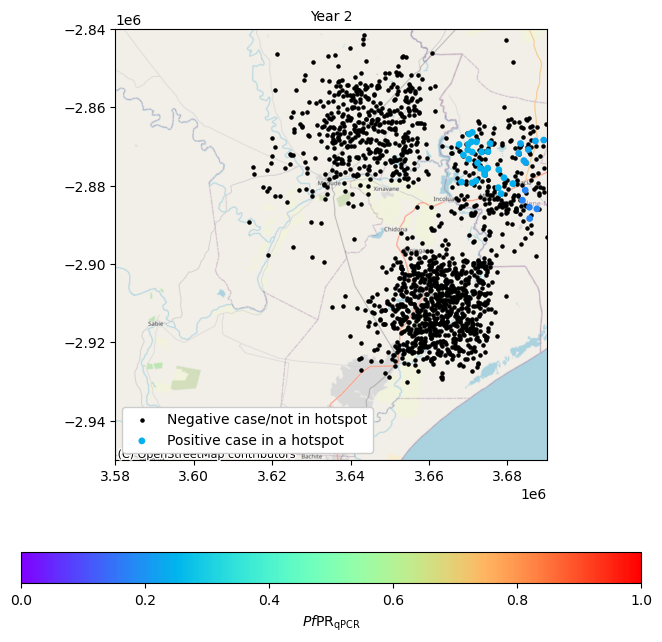

Number of FOFs: 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


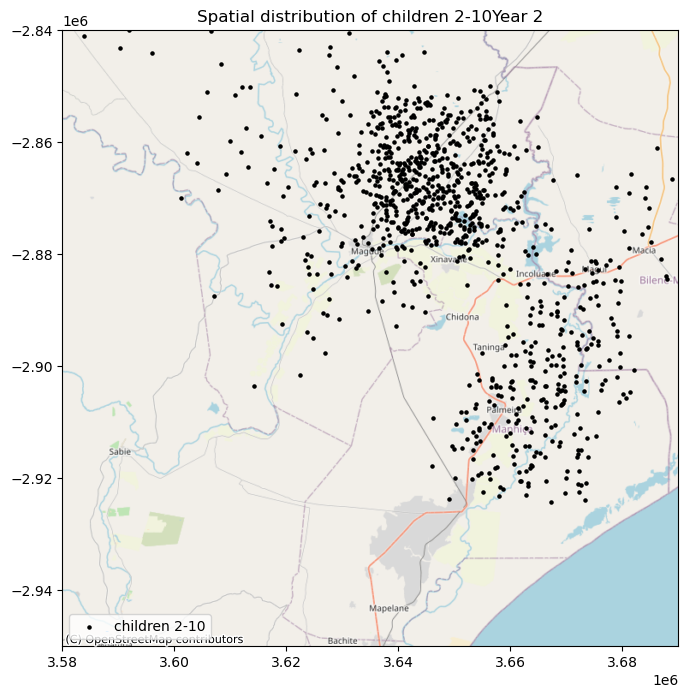

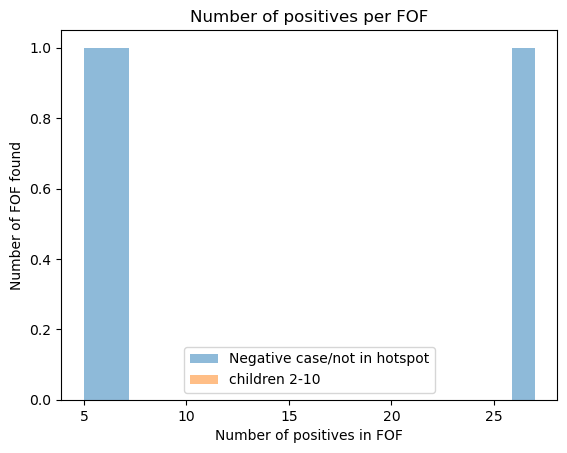

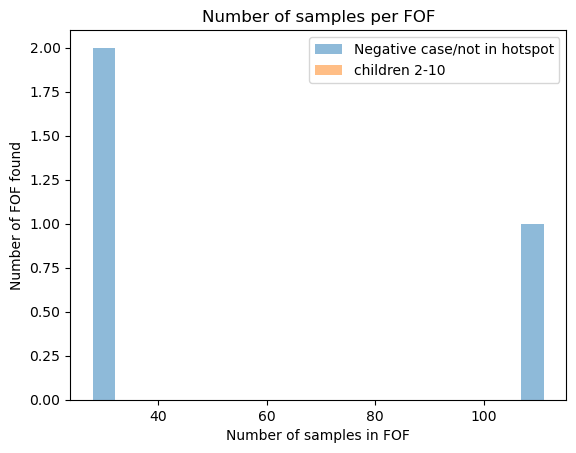

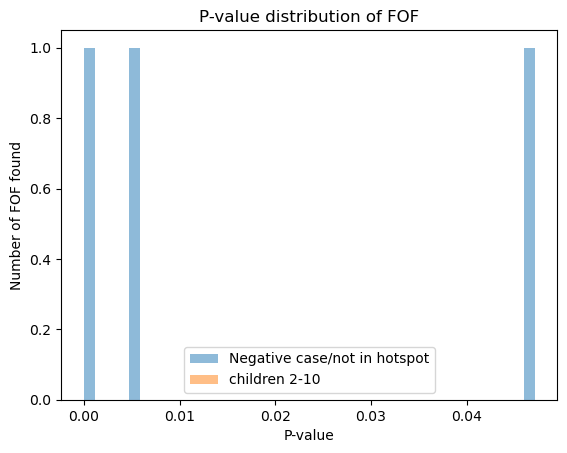

------------ Year 3  -------------
Sample sizes:
MiPMon All ANC visits: 1469
Children 2-10: 544
---------- Linking distance = 3000  ----------
Number of FOFs in Negative case/not in hotspot: 9
Number of FOFs in Negative case/not in hotspot with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0
Number of FOFs in children 2-10: 2
Number of FOFs in children 2-10 with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0


In [7]:
print("----------------------------------------")
time_width = None
print("------------ Time window:", time_width, " -------------")
selection = 'All ANC visits'
mip_sel = mipmon_selection[selection]
for year in years:
    print("------------ Year", year, " -------------")
    c210_mask_year, mip_mask_year = spatial_utils.get_time_masks(cross210, mipmon, year, \
                                                                 time_width = time_width, \
                                                                 verbose = False)
    
    #Define data for FOF input
    print("Sample sizes:")
    print("MiPMon", selection+':', np.sum(mip_mask_year&mip_sel))
    print("Children 2-10:", np.sum(c210_mask_year&has_pcr_cross&cross210_area_mask))
    mipmon_positions, cross210_positions, mipmon_test, cross210_test = \
    spatial_utils.get_pos_test(mipmon, mip_mask_year&mip_sel, cross210, c210_mask_year&has_pcr_cross&cross210_area_mask)
    
    for linking_d in [3000]:
        
        print("---------- Linking distance =", linking_d, " ----------")
        fofid_mip, mean_pr_fof_mip, pval_fof_mip, fof_catalogue_mip, fofid_c210, \
        mean_pr_fof_c210, pval_fof_c210, \
        fof_catalogue_c210 = spatial_utils.get_fof_data(linking_d, mipmon_positions, mipmon_test, \
                                                        cross210_positions, cross210_test)
        spatial_utils.visualise_all_fofs(fof_catalogue_mip, fof_catalogue_c210, mipmon, cross210, \
                                         mip_pcrpos, cross210_pcrpos, \
                                         mip_mask_year&mip_sel, c210_mask_year&has_pcr_cross&cross210_area_mask, \
                                         mean_pr_fof_mip, mean_pr_fof_c210, \
                                         fofid_mip, fofid_c210, \
                                         min_size_fof=5, min_pr_fof = .0, max_p_fof = 0.05, \
                                        xlims = xlims, ylims = ylims, extra_title = "Year " + str(year), \
                                        pop1name = "Negative case/not in hotspot", pos1name = "Positive case in a hotspot", \
                                        cmap = 'rainbow')

In [8]:
spatial_utils.visualise_all_fofs(fof_catalogue_mip, fof_catalogue_c210, mipmon, cross210, \
                                         mip_pcrpos, cross210_pcrpos, \
                                         mip_mask_year&mip_sel, c210_mask_year&has_pcr_cross&cross210_area_mask, \
                                         mean_pr_fof_mip, mean_pr_fof_c210, \
                                         fofid_mip, fofid_c210, \
                                         min_size_fof=5, min_pr_fof = .0, max_p_fof = 0.05, \
                                        xlims = xlims, ylims = ylims, extra_title = "Year " + str(year), \
                                        pop1name = "Negative case/not in hotspot", pos1name = "Positive case in a hotspot", \
                                        cmap = 'rainbow')

Number of FOFs in Negative case/not in hotspot: 9
Number of FOFs in Negative case/not in hotspot with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0
Number of FOFs in children 2-10: 2
Number of FOFs in children 2-10 with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0


0

In [9]:
fof_catalogue_c210

,id,mean_pos,mean_pos_ext,mean_pr,positives,negatives,total,indeces,geometry,p
0,1.0,"[3659109.349816543, -2905136.1481071576]","[3659089.663436528, -2905394.6011269432]",0.142857,2,12,14,"[321, 322, 335, 340, 345, 349, 395, 402, 465, ...",POINT (3659109.350 -2905136.148),0.062278
1,2.0,"[3669231.914563425, -2903005.8849079497]","[3670142.8484278307, -2904254.8174745985]",0.250000,2,6,8,"[328, 344, 359, 410, 455, 476, 492, 514]",POINT (3669231.915 -2903005.885),0.021524


#### RDT

----------------------------------------
------------ Time window: None  -------------
------------ Year 1  -------------
Sample sizes:
MiPMon All ANC visits: 1971
Children 2-10: 1914
---------- Linking distance = 3000  ----------
Number of FOFs in MiPMon: 14
Number of FOFs in MiPMon with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 2
Number of FOFs in children 2-10: 9
Number of FOFs in children 2-10 with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


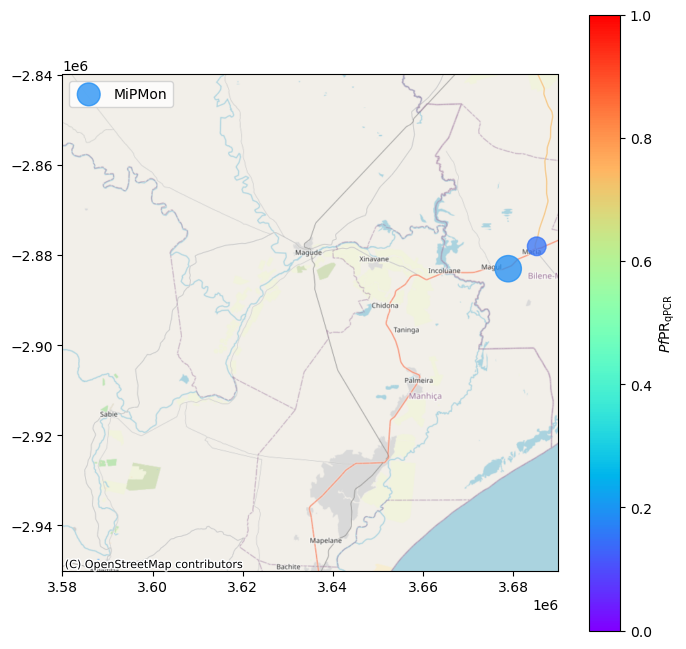

Number of FOFs: 2


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


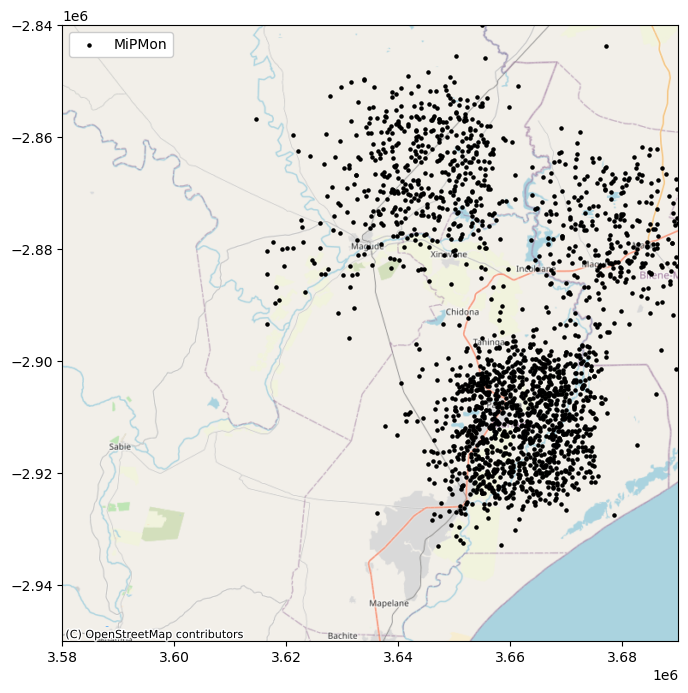

Number of FOFs: 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


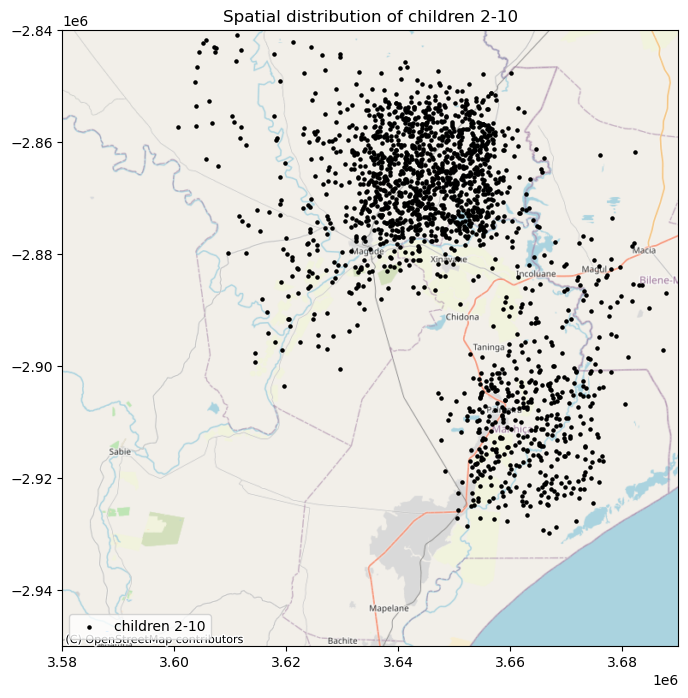

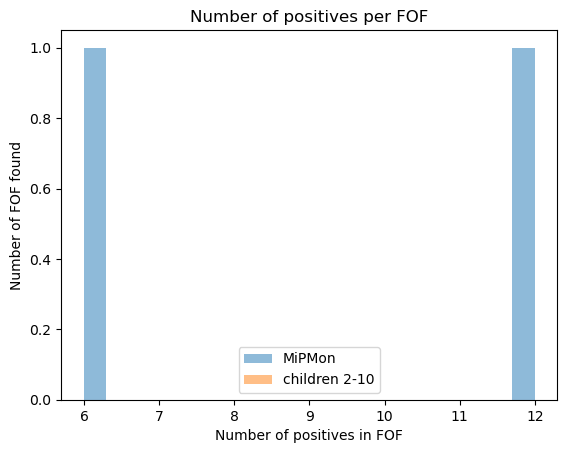

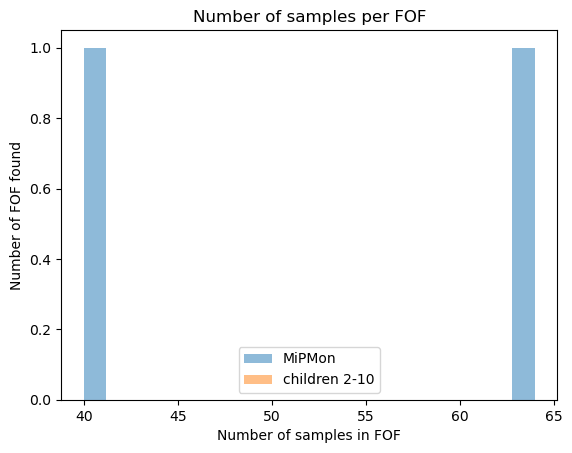

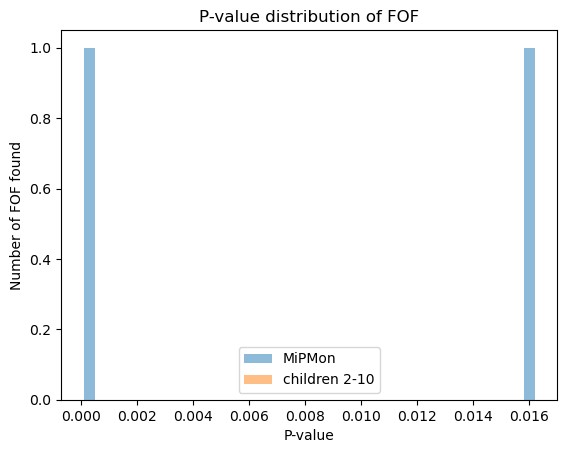

------------ Year 2  -------------
Sample sizes:
MiPMon All ANC visits: 1613
Children 2-10: 980
---------- Linking distance = 3000  ----------
Number of FOFs in MiPMon: 9
Number of FOFs in MiPMon with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 1
Number of FOFs in children 2-10: 7
Number of FOFs in children 2-10 with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


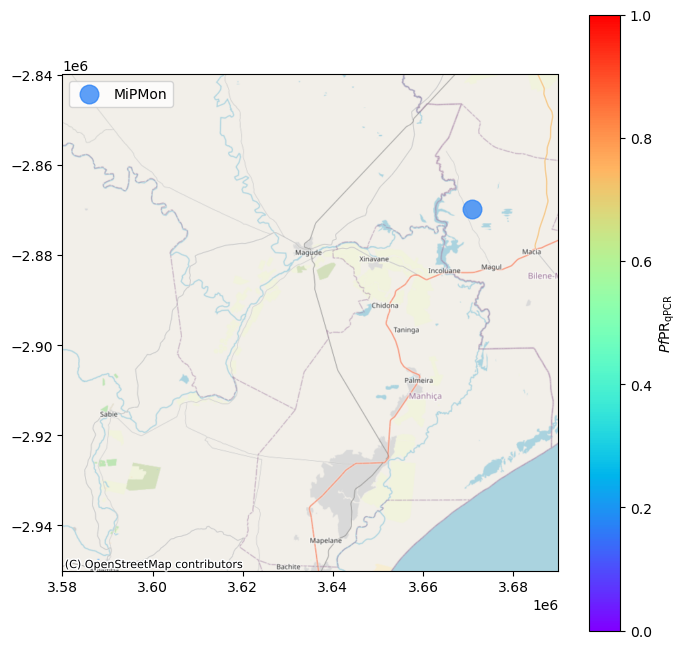

Number of FOFs: 1


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


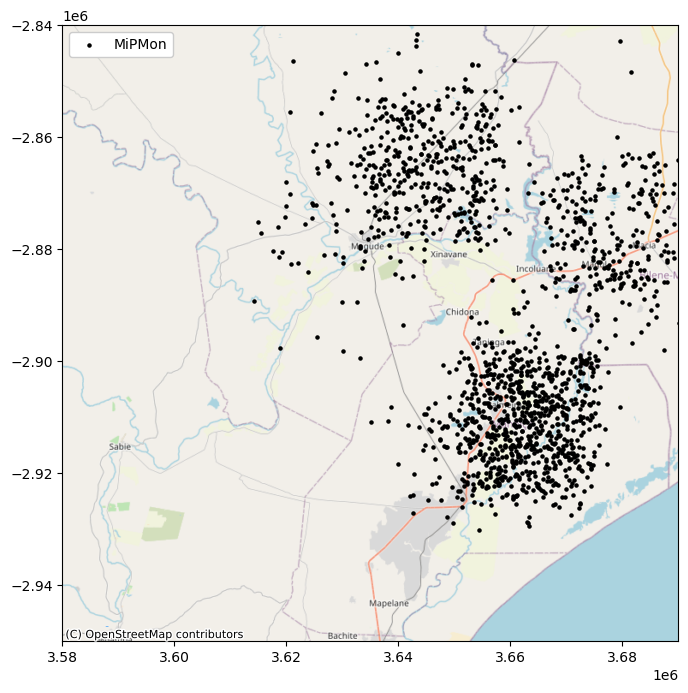

Number of FOFs: 0


/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


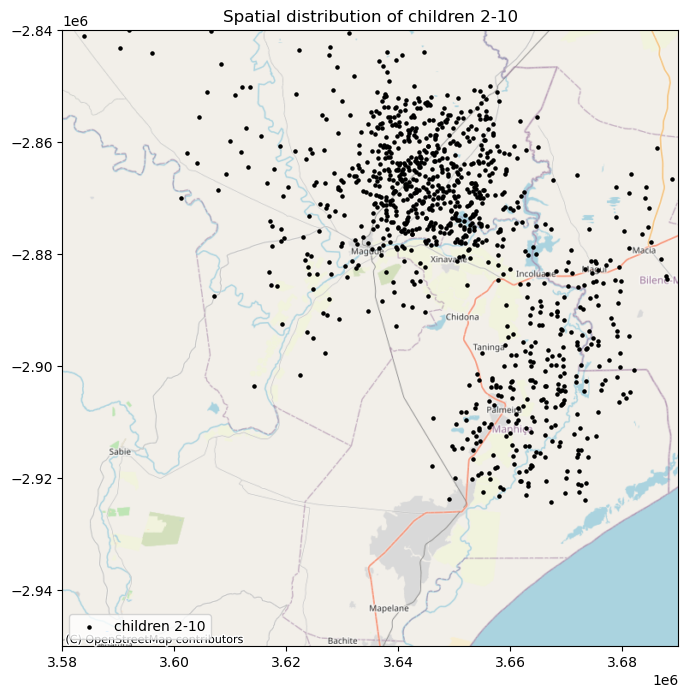

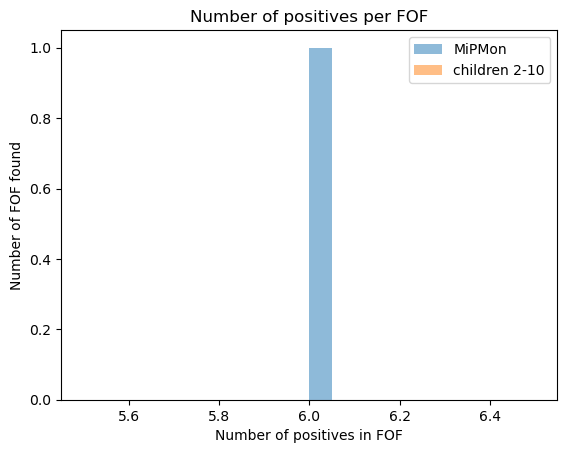

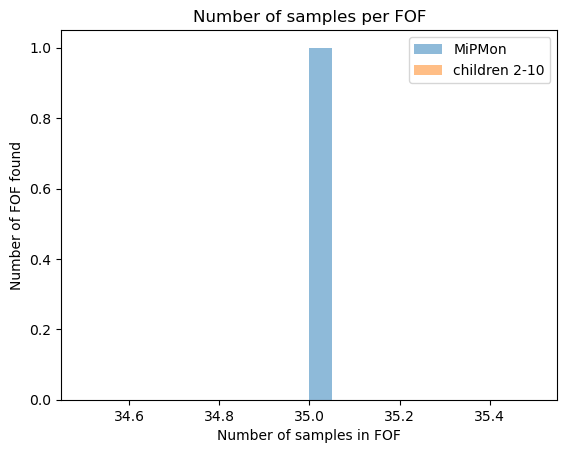

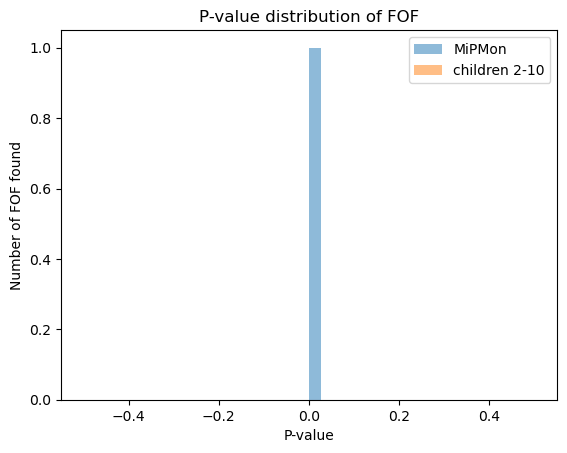

------------ Year 3  -------------
Sample sizes:
MiPMon All ANC visits: 1469
Children 2-10: 544
---------- Linking distance = 3000  ----------
Number of FOFs in MiPMon: 1
Number of FOFs in MiPMon with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0
Number of FOFs in children 2-10: 2
Number of FOFs in children 2-10 with >= 5 positives and PR>=0.0 and p-value <= 0.05 : 0


In [10]:
print("----------------------------------------")
time_width = None
print("------------ Time window:", time_width, " -------------")
selection = 'All ANC visits'
mip_sel = mipmon_selection[selection]
for year in years:
    print("------------ Year", year, " -------------")
    c210_mask_year, mip_mask_year = spatial_utils.get_time_masks(cross210, mipmon, year, \
                                                                 time_width = time_width, \
                                                                 verbose = False)
    
    #Define data for FOF input
    print("Sample sizes:")
    print("MiPMon", selection+':', np.sum(mip_mask_year&mip_sel))
    print("Children 2-10:", np.sum(c210_mask_year&has_pcr_cross&cross210_area_mask))
    mipmon_positions, cross210_positions, mipmon_test, cross210_test = \
    spatial_utils.get_pos_test(mipmon, mip_mask_year&mip_sel, cross210, c210_mask_year&has_pcr_cross&cross210_area_mask, \
                              pos1_name = 'rdt')
    
    for linking_d in [3000]:
        
        print("---------- Linking distance =", linking_d, " ----------")
        fofid_mip, mean_pr_fof_mip, pval_fof_mip, fof_catalogue_mip, fofid_c210, \
        mean_pr_fof_c210, pval_fof_c210, \
        fof_catalogue_c210 = spatial_utils.get_fof_data(linking_d, mipmon_positions, mipmon_test, \
                                                        cross210_positions, cross210_test)
        spatial_utils.visualise_all_fofs(fof_catalogue_mip, fof_catalogue_c210, mipmon, cross210, \
                                         mip_rdtpos, cross210_pcrpos, \
                                         mip_mask_year&mip_sel, c210_mask_year&has_pcr_cross&cross210_area_mask, \
                                         mean_pr_fof_mip, mean_pr_fof_c210, \
                                         pval_fof_mip, pval_fof_c210, \
                                         min_size_fof=5, min_pr_fof = .0, max_p_fof = 0.05, \
                                        xlims = xlims, ylims = ylims)